# Assess the Hybrid Catalgoue

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyoorb as oo
import astropy.units as u
from astroML.density_estimation import KNeighborsDensity
from matplotlib.colors import LogNorm, Normalize, CenteredNorm

In [2]:
plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.9 * fs,
          'ytick.labelsize': 0.9 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

%config InlineBackend.figure_format = "retina"

In [3]:
hybrid = pd.read_hdf("../../catalogues/hybrid.h5", key="df")

In [4]:
s3m = pd.read_hdf("../../catalogues/s3m_propagated_cart.h5", key="df")

In [5]:
import sys
sys.path.append("../../hybridcat/hybridcat/")
import transform

In [6]:
hybrid_cart = transform.transform_catalogue(hybrid, current_coords="COM",
                                            transformed_coords="CART", initialise=True)

# Compare CDFs of S3m and Hybrid

In [7]:
hybrid_col = plt.get_cmap("viridis")(0.3)
s3m_col = plt.get_cmap("viridis")(0.7)

H done
x done
y done
z done
vx done
vy done
vz done


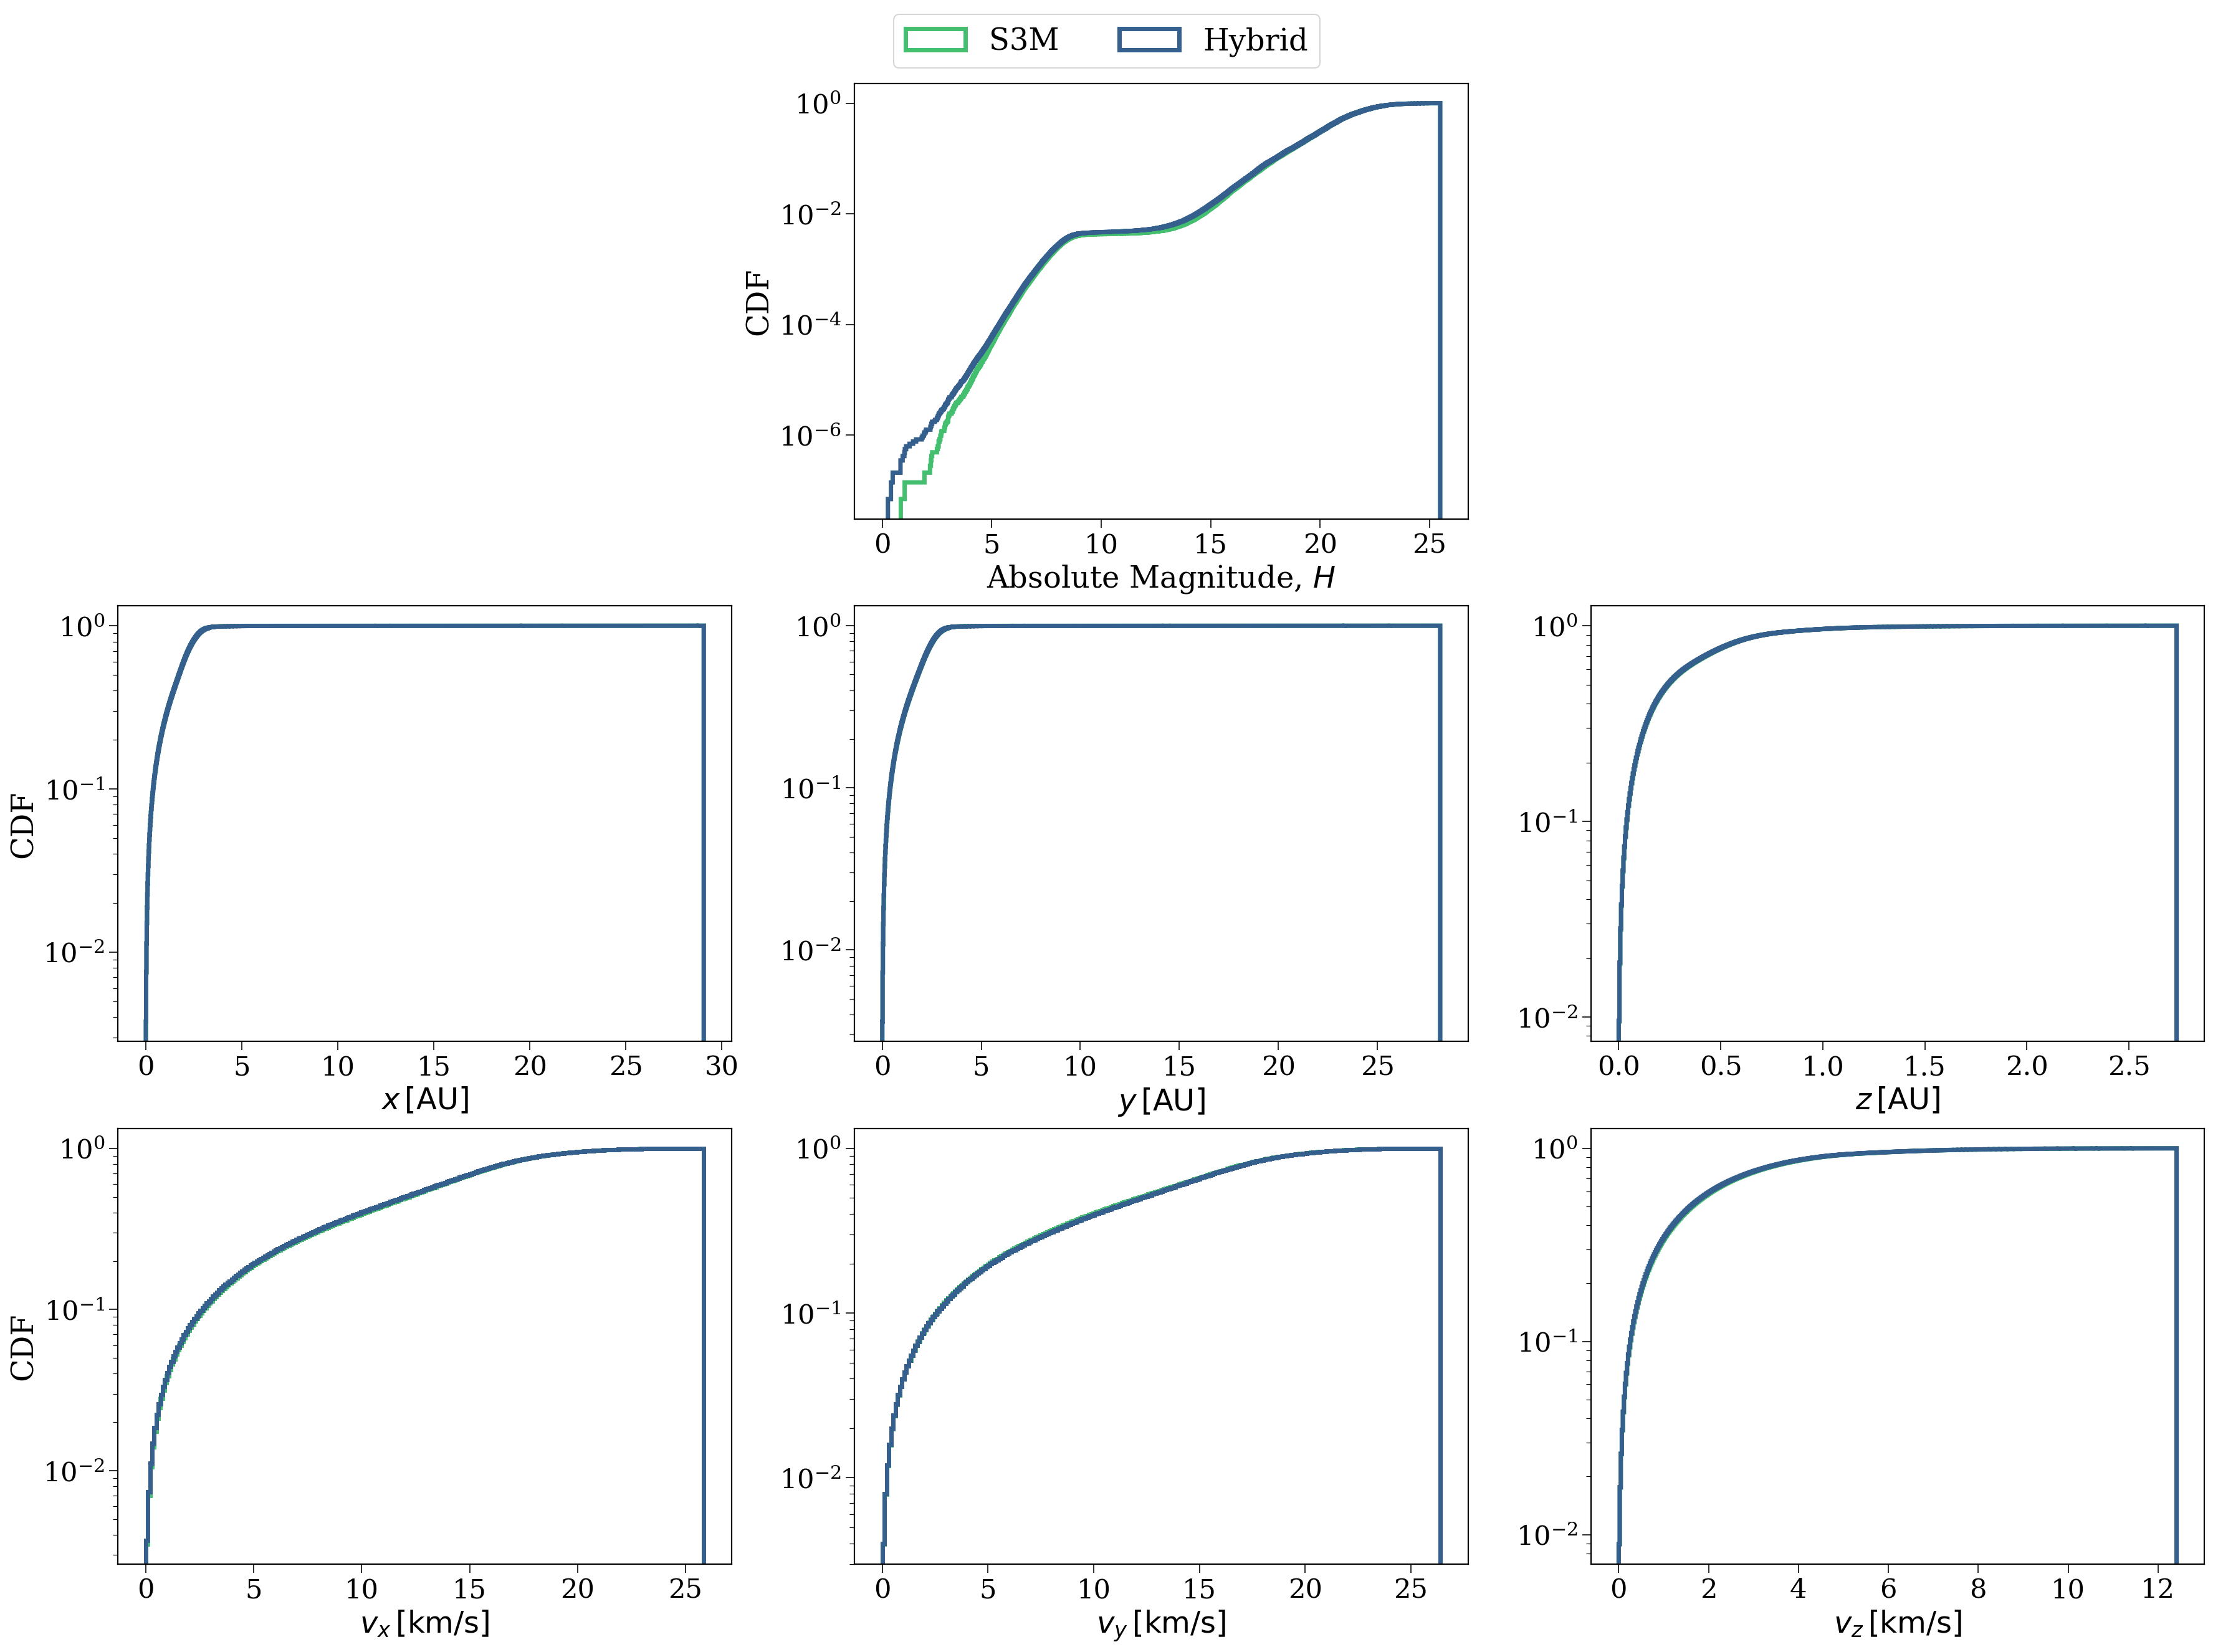

In [8]:
variables = ["H", "x", "y", "z", "vx", "vy", "vz"]
labels = [r"Absolute Magnitude, $H$", r"$x \, [\rm AU]$", r"$y \, [\rm AU]$", r"$z \, [\rm AU]$",
          r"$v_x \, [\rm km / s]$", r"$v_y \, [\rm km / s]$", r"$v_z \, [\rm km / s]$"]

fig, axes = plt.subplots(3, 3, figsize=(30, 20))
flat_axes = np.concatenate([[axes.flatten()[1]], axes.flatten()[3:]])

every = 1

lw = 3.5
ls = "-"

for ax, var, label in zip(flat_axes, variables, labels):
    conversion = (u.AU / u.day).to(u.km / u.s) if var in ["vx", "vy", "vz"] else 1
    max_val = np.percentile(s3m[var][::every] * conversion, 99.9)
    ax.hist(s3m[var][::every] * conversion, bins="fd", cumulative=True, density=True, histtype="step",
            lw=lw, color=s3m_col, label="S3M", range=(0, max_val), log=True, linestyle=ls)
    ax.hist(hybrid_cart[var][::every] * conversion, bins="fd", cumulative=True, density=True, histtype="step",
            lw=lw, color=hybrid_col, label="Hybrid", range=(0, max_val), log=True, linestyle=ls)
    ax.set_xlabel(label)
    print(var, "done")
    
handles, labels = axes[0, 1].get_legend_handles_labels()
    
fig.subplots_adjust(top=0.95)
fig.legend(handles=handles, labels=labels, ncol=2, loc="upper center")

for ax in [axes[0, 1], axes[1, 0], axes[2, 0]]:
    ax.set_ylabel("CDF")
    
for ax in [axes[0, 0], axes[0, 2]]:
    ax.axis("off")
    
plt.savefig("../figures/hybrid_vs_s3m_distributions.pdf", format="PDF", bbox_inches="tight")
    
plt.show()

# Density comparison

## Read in the data
For the density estimation, I read in the full mpcorb file and mask the S3m file so that I only make the density for the objects that "matched" with mpcorb objects in the merge (and so should be very similar)

In [9]:
# read in entire MPCORB file that has been propagated and in cartesian coordinates
mpcorb = pd.read_hdf("../../catalogues/mpcorb_propagated_cart.h5")

In [10]:
# loop over the merge output to get the ids that matched mpcorb
delete_these = []
H_bins = np.arange(-2, 28 + 1)
for left, right in zip(H_bins[:-1], H_bins[1:]):
    matched = np.load("../../output/matched_{}_{}.npy".format(left, right))
    delete_these.extend(matched)

In [11]:
# keep only those ids
remaining_s3m = s3m[np.isin(s3m["id"].values, delete_these)]

## Set up the density estimators

In [12]:
# get just the x, y, z for mpcorb
mpc_xyz = np.array([mpcorb.x, mpcorb.y, mpcorb.z]).T

# create a density estimator and fit to (x, y, z)
mpc_estimator = KNeighborsDensity()
mpc_estimator.fit(mpc_xyz)

# same for S3m
s3m_xyz = np.array([remaining_s3m.x, remaining_s3m.y, remaining_s3m.z]).T

s3m_estimator = KNeighborsDensity()
s3m_estimator.fit(s3m_xyz)

In [13]:
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 101)
z = np.linspace(-3, 3, 102)

X, Y, Z = np.meshgrid(x, y, z, indexing="ij")
grid = np.array([X.ravel(),Y.ravel(),Z.ravel()]).T
grid_shape = X.shape

In [14]:
%%time
mpc_density_zoomed = mpc_estimator.eval(grid)
mpc_density_zoomed /= mpc_density_zoomed.sum()

CPU times: user 9min 7s, sys: 4.47 s, total: 9min 12s
Wall time: 9min 12s


In [15]:
%%time
s3m_density_zoomed = s3m_estimator.eval(grid)
s3m_density_zoomed /= s3m_density_zoomed.sum()

CPU times: user 3min 57s, sys: 2.15 s, total: 4min
Wall time: 4min


## Plot the densities

In [24]:
def plot_x_y_density(density, x, y, grid_shape, label, norm=LogNorm(), cmap="magma", fig=None, ax=None):
    if fig is None or ax is None:
        fig, ax = plt.subplots()
    
    X, Y = np.meshgrid(x, y)
    img = density.reshape(grid_shape).sum(axis=2).T
    
    ax.annotate(label, xy=(0.98, 0.98), xycoords="axes fraction",
                ha="right", va="top", color="white", fontsize=fs)
    
    mesh = ax.pcolormesh(X, Y, img, shading="nearest", norm=norm, cmap=cmap, rasterized=True)
    mesh.set_edgecolor("face")
    cbar = fig.colorbar(mesh, label="Density", ax=ax)
    
    ax.set_aspect("equal")
    ax.set_xlabel(r"Heliocentric $x \, [\rm AU]$")
    ax.set_ylabel(r"Heliocentric $y \, [\rm AU]$")
    
    return fig, ax

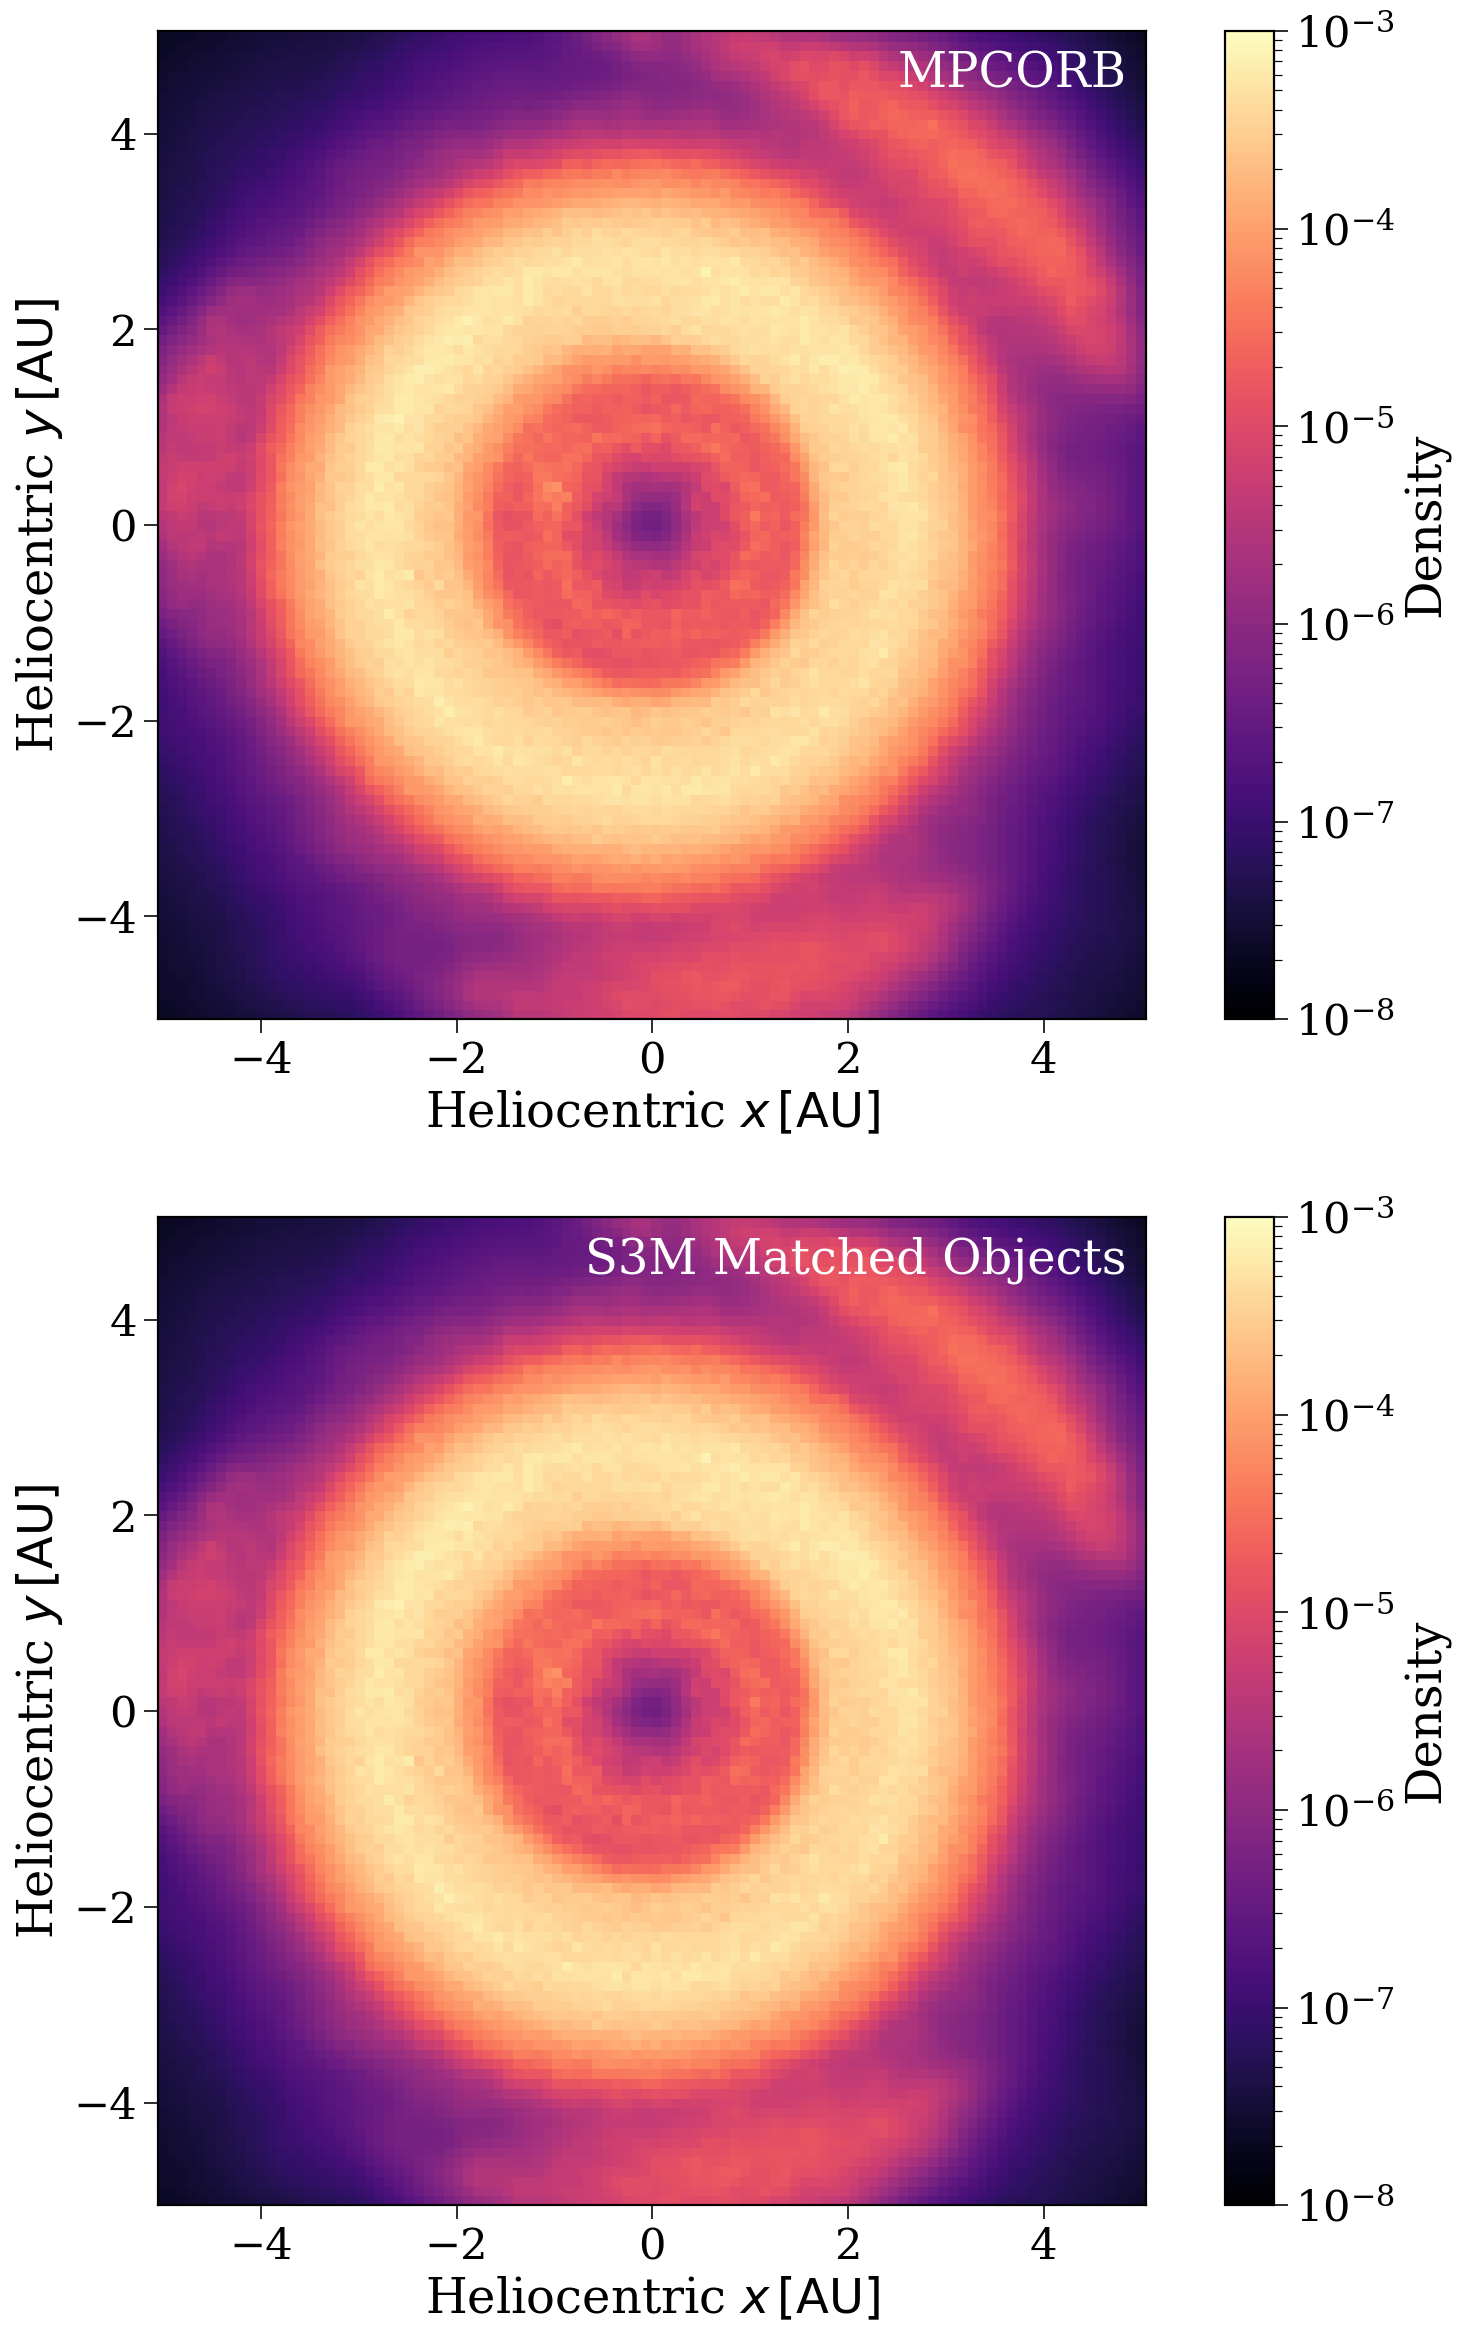

In [25]:
fig, axes = plt.subplots(2, 1, figsize=(14, 20))

fig, axes[0] = plot_x_y_density(mpc_density_zoomed, x, y, grid_shape, label="MPCORB",
                                norm=LogNorm(vmin=1e-8, vmax=1e-3), fig=fig, ax=axes[0])
fig, axes[1] = plot_x_y_density(mpc_density_zoomed, x, y, grid_shape, label="S3M Matched Objects",
                                norm=LogNorm(vmin=1e-8, vmax=1e-3), fig=fig, ax=axes[1])

plt.savefig("../figures/density_comparisons.pdf", format="pdf", bbox_inches="tight")

plt.show()

## Plot the ratios

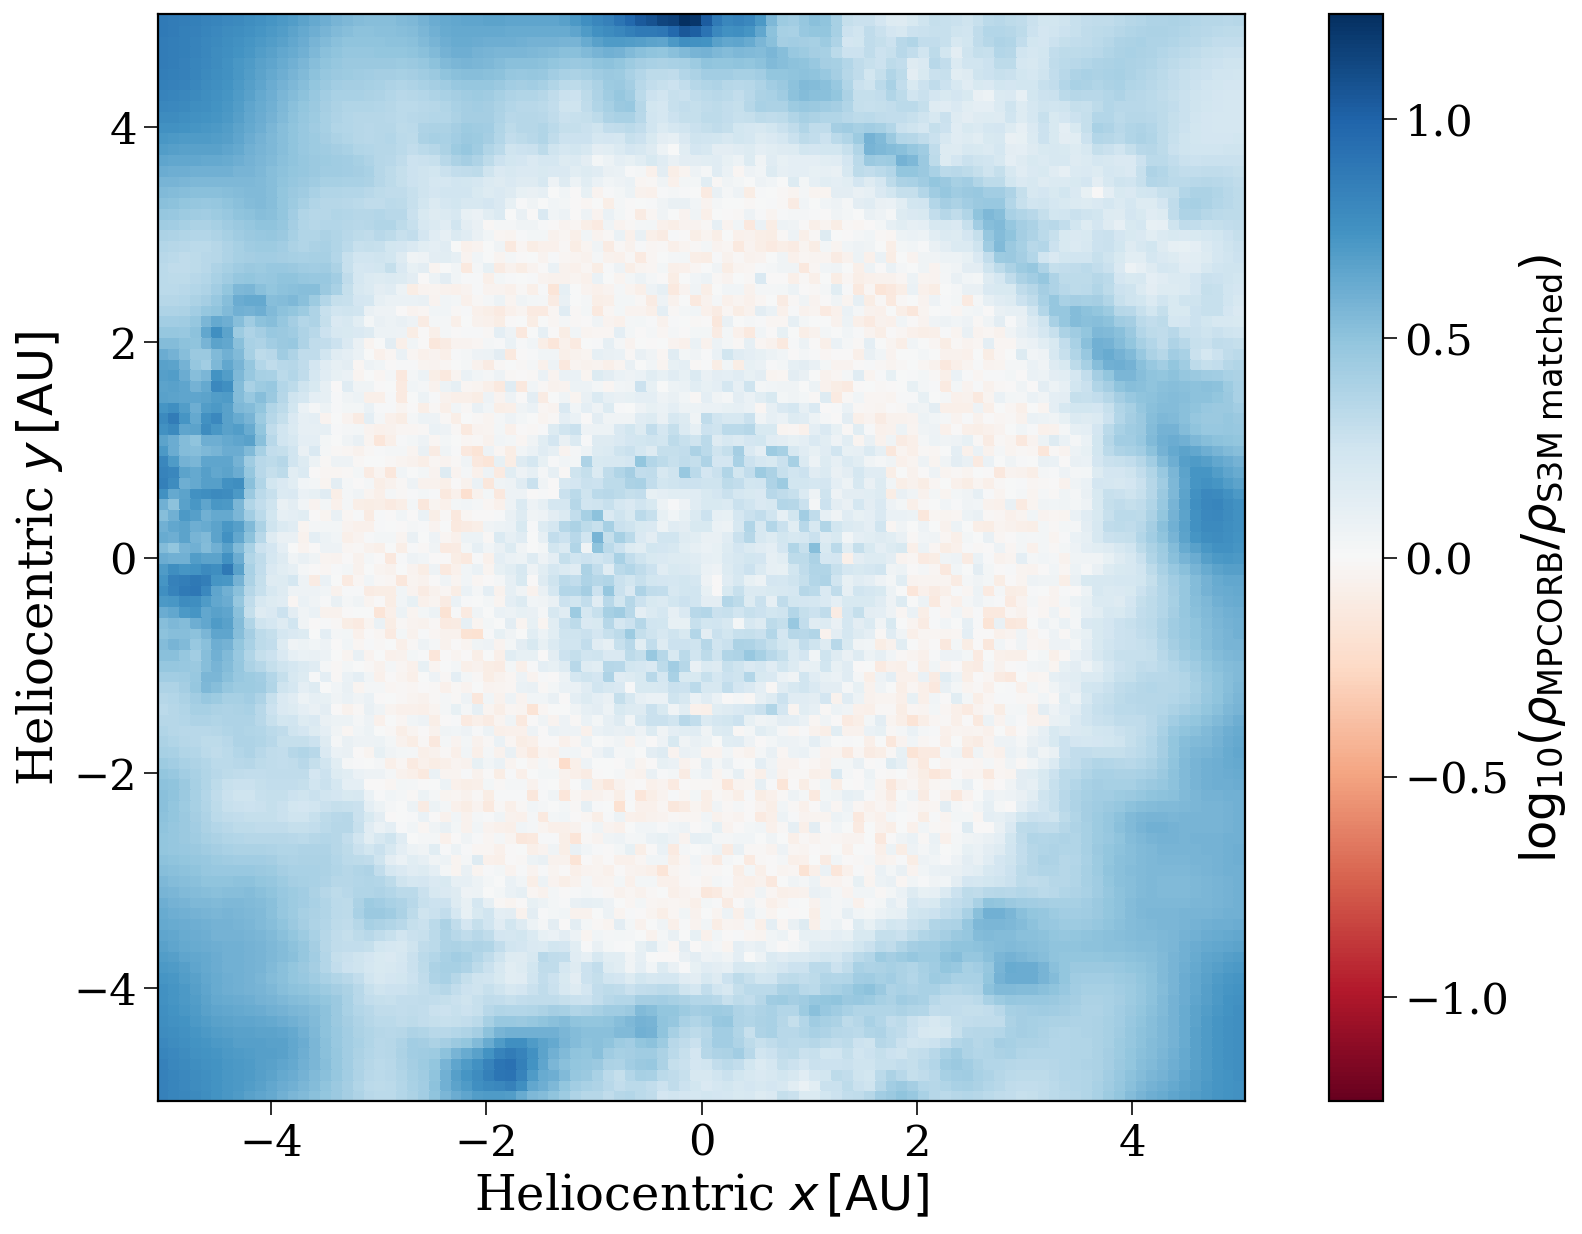

In [26]:
fig, ax = plt.subplots(figsize=(15, 10))

X, Y = np.meshgrid(x, y)
mpc_img = mpc_density_zoomed.reshape(grid_shape).sum(axis=2).T
s3m_img = s3m_density_zoomed.reshape(grid_shape).sum(axis=2).T
res_img = mpc_img / s3m_img

mesh = ax.pcolormesh(X, Y, np.log10(res_img), shading="nearest", cmap="RdBu",
                     norm=CenteredNorm(vcenter=0.0), rasterized=True)
mesh.set_edgecolor("face")
cbar = fig.colorbar(mesh, label=r"$\log_{10}(\rho_{\rm MPCORB} / \rho_{\rm S3M\ matched})$", ax=ax)

ax.set_aspect("equal")
ax.set_xlabel(r"Heliocentric $x \, [\rm AU]$")
ax.set_ylabel(r"Heliocentric $y \, [\rm AU]$")

plt.savefig("../figures/density_residuals.pdf", format="pdf", bbox_inches="tight")

plt.show()